In [1]:
import pickle
import pandas as pd
import numpy as np
from keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout,BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.
C:\Users\Acer\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Acer\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Acer\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Acer\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

## Preparing Data

In [2]:
df = pd.read_csv('D:\\Programming\\Python\\Neural Network\\Live Emotion Detection\\Emotion Detection\\Raw_Data/train.csv')

In [3]:
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
df['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [5]:
df.emotion.value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

In [6]:
emotion_label = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

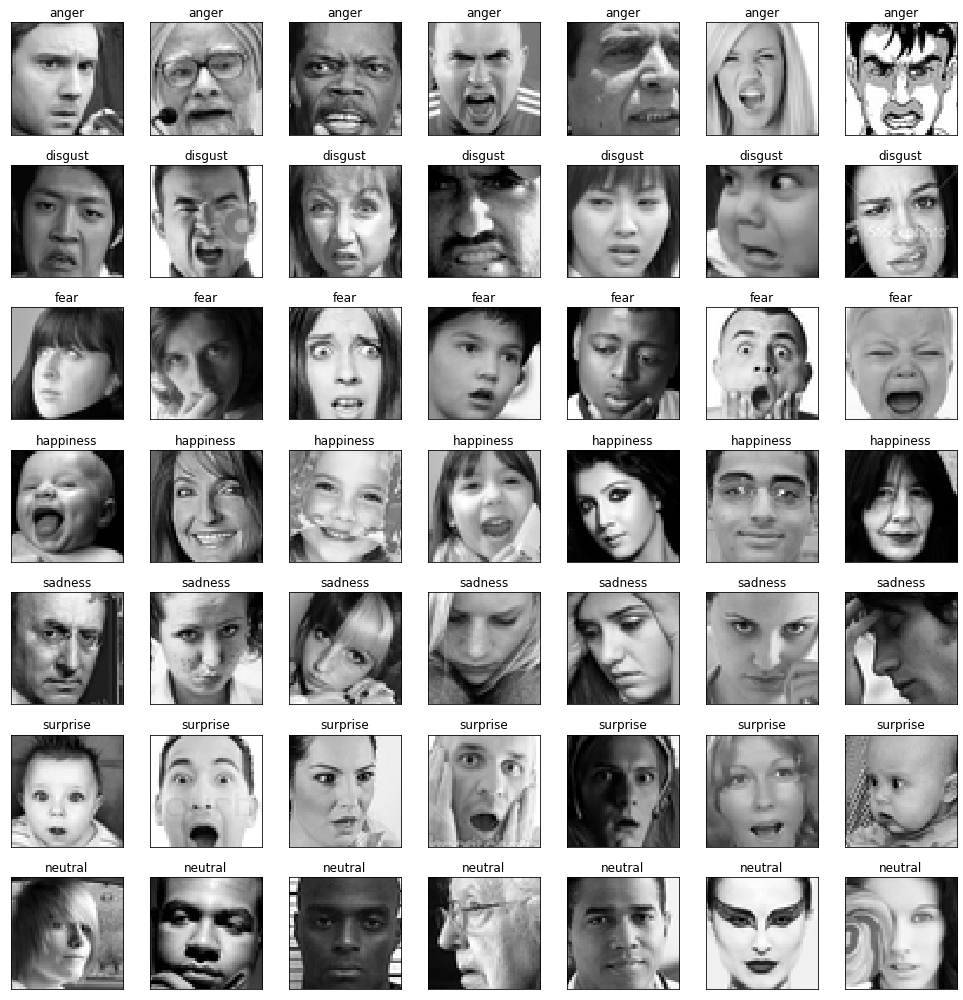

In [7]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label[label])
        plt.tight_layout()

In [8]:
# INTERESTED_LABELS = [3, 4, 6, 2] #todo remove 2 and add 0

In [9]:
INTERESTED_LABELS = [3, 4, 6, 0, 2]

In [10]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(25102, 2)

In [11]:
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [12]:
le = LabelEncoder()

In [13]:
y = le.fit_transform(df.emotion)
y = to_categorical(y)
y.shape

(25102, 5)

In [14]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 2: 1, 3: 2, 4: 3, 6: 4}


In [15]:
neo_emotion_label = {0:'anger', 1:'fear', 2:'happiness', 3:'sadness', 4:'neutral'}

In [16]:
x = []
for pix in df.pixels:
    pix_list = pix.split(' ')
    pix_val = []
    for pixel in pix_list:
        pix_val.append(float(pixel))
    pix_val = np.reshape(pix_val,(48,48,1))
    x.append(pix_val)

In [17]:
X = np.array(x)

In [18]:
X.shape

(25102, 48, 48, 1)

In [19]:
X = X/255

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.1)


In [21]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((22591, 48, 48, 1), (2511, 48, 48, 1), (22591, 5), (2511, 5))

## Preparing Model 

In [22]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [26]:
def build_model():

    model = Sequential()

    model.add(Conv2D(64,(3,3),input_shape=(48,48,1),activation='elu',kernel_initializer='he_normal',padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(64,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D((2,2)))

    model.add(Dropout(0.5))

    model.add(Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D((2,2)))

    model.add(Dropout(0.5))

    model.add(Conv2D(256,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(256,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(512,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(512,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D((2,2)))

    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(128,activation='elu',kernel_initializer='he_normal'))
    model.add(BatchNormalization())

    model.add(Dropout(0.6))

    model.add(Dense(5,activation='softmax'))

    model.compile(metrics=['accuracy'],optimizer='adam',loss='categorical_crossentropy')

    model.summary()
    
    return model

## Using Image Data Generator

In [27]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    )
datagen.fit(X_train)

## Fitting Model

In [28]:
model = build_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_10 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 128)      

In [29]:
history = model.fit_generator(
    datagen.flow(X_train,y_train,batch_size=32),
    epochs=100,
    verbose=1,
    validation_data=(X_val,y_val),
    callbacks=callbacks
    )


Epoch 1/100
706/706 [==============================] - 60s 86ms/step - loss: 1.9096 - accuracy: 0.2490 - val_loss: 1.5455 - val_accuracy: 0.3078
Epoch 2/100
706/706 [==============================] - 57s 81ms/step - loss: 1.5411 - accuracy: 0.3268 - val_loss: 1.3764 - val_accuracy: 0.4170
Epoch 3/100
706/706 [==============================] - 59s 83ms/step - loss: 1.3983 - accuracy: 0.4046 - val_loss: 1.2061 - val_accuracy: 0.4950
Epoch 4/100
706/706 [==============================] - 61s 86ms/step - loss: 1.2846 - accuracy: 0.4689 - val_loss: 1.1418 - val_accuracy: 0.5504
Epoch 5/100
706/706 [==============================] - 62s 88ms/step - loss: 1.2228 - accuracy: 0.5034 - val_loss: 1.1208 - val_accuracy: 0.5492
Epoch 6/100
706/706 [==============================] - 66s 93ms/step - loss: 1.1664 - accuracy: 0.5283 - val_loss: 1.0468 - val_accuracy: 0.5798
Epoch 7/100
706/706 [==============================] - 67s 95ms/step - loss: 1.1283 - accuracy: 0.5484 - val_loss: 1.0027 - val_a

706/706 [==============================] - 64s 91ms/step - loss: 0.6033 - accuracy: 0.7780 - val_loss: 0.9232 - val_accuracy: 0.6874
Epoch 56/100
706/706 [==============================] - 64s 91ms/step - loss: 0.5995 - accuracy: 0.7781 - val_loss: 0.9181 - val_accuracy: 0.6906
Epoch 57/100
706/706 [==============================] - 65s 92ms/step - loss: 0.5822 - accuracy: 0.7888 - val_loss: 0.9544 - val_accuracy: 0.6937

Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 58/100
706/706 [==============================] - 64s 91ms/step - loss: 0.5706 - accuracy: 0.7921 - val_loss: 0.9367 - val_accuracy: 0.7013
Epoch 59/100
706/706 [==============================] - 64s 91ms/step - loss: 0.5573 - accuracy: 0.7963 - val_loss: 0.9450 - val_accuracy: 0.6973
Epoch 60/100
706/706 [==============================] - 66s 93ms/step - loss: 0.5574 - accuracy: 0.7991 - val_loss: 0.9350 - val_accuracy: 0.6941
Epoch 61/100
706/706 [==============================] - 

In [30]:
model.save("Model/FED-48x48x1-CNN_IDG_ELU_21102020_1830.model")

## Result Analysis

In [31]:
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix

total wrong validation predictions: 290


              precision    recall  f1-score   support

           0       0.66      0.61      0.63       126
           1       0.61      0.58      0.59       162
           2       0.91      0.87      0.89       280
           3       0.60      0.58      0.59       195
           4       0.67      0.76      0.71       237

    accuracy                           0.71      1000
   macro avg       0.69      0.68      0.68      1000
weighted avg       0.71      0.71      0.71      1000



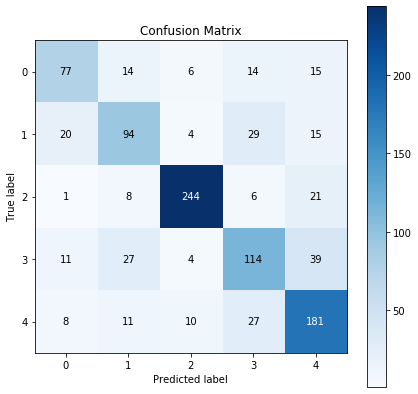

In [32]:
yhat_valid = model.predict_classes(X_val[0:1000])
plot_confusion_matrix(np.argmax(y_val[0:1000], axis=1), yhat_valid, figsize=(7,7))
plt.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_val[0:1000], axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_val[0:1000], axis=1), yhat_valid))

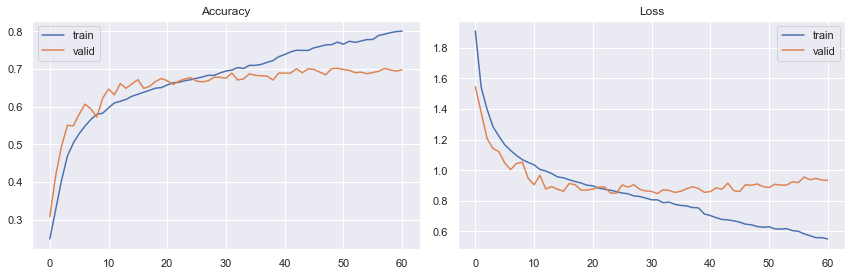

In [33]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

# plt.savefig('epoch_history_dcnn.png')
plt.show()

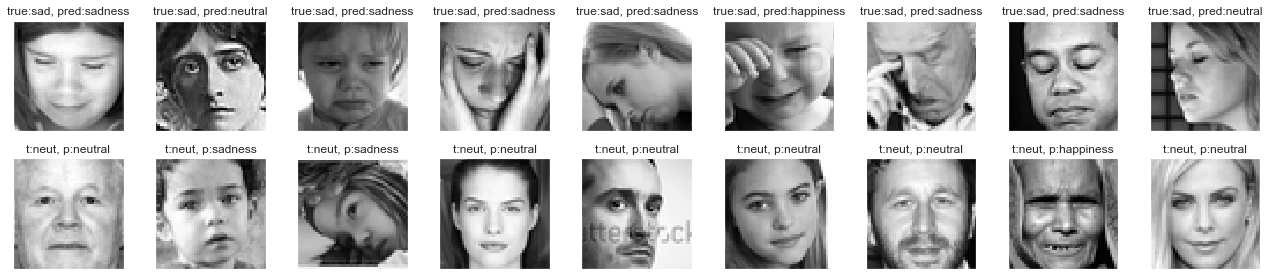

In [34]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_val[:, 3]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_val[:, 4 ]==1)[0], size=9)

fig = plt.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = plt.subplot(2, 9, i+1)
        sample_img = X_val[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{neo_emotion_label[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        ax = plt.subplot(2, 9, i+10)
        sample_img = X_val[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{neo_emotion_label[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        plt.tight_layout()